# Object Detection Using Custom YOLOv8 Object Detector

Import needed modules

In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### The dataset is structured in the following manner:

```
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset contains number of classes: [ ... ]

The following block shows the contents of the `data.yaml` file.

```yaml
path: ../Cars Detection
train: train/images
val: valid/images

nc: 5
names: ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
```

----------------------------------------------------

# Create needed functions

### Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.

In [ ]:
'''The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format.
    Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format to check these annotations'''

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [ ]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

### Function to plot images with the bounding boxes.

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

### Visualize images sample.

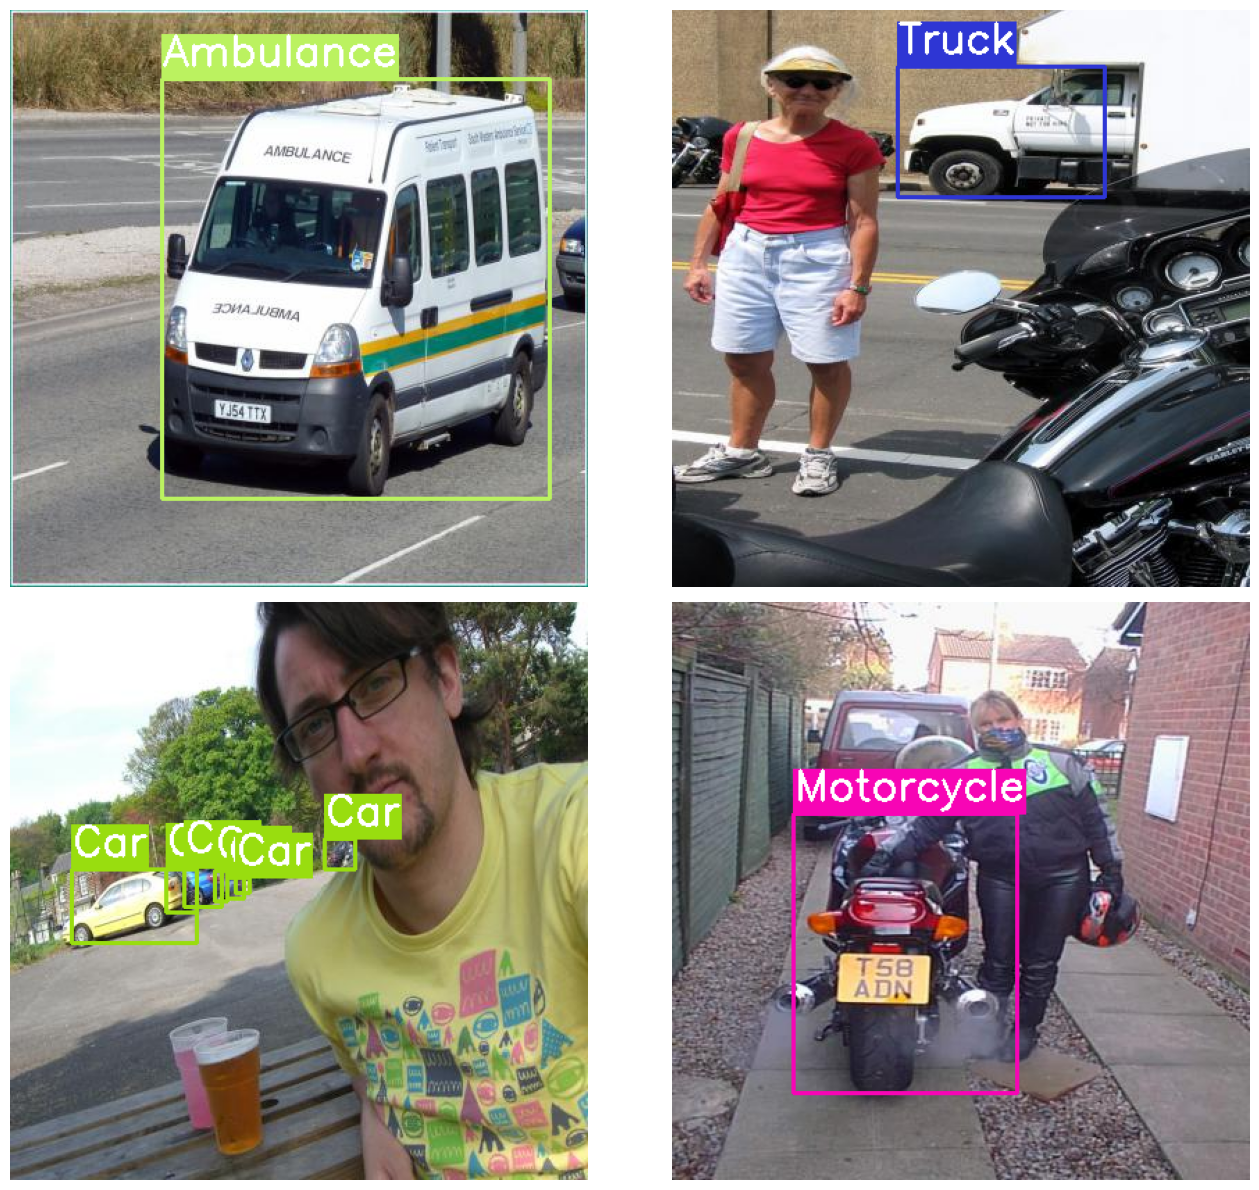

In [ ]:
plot(image_paths='/content/drive/MyDrive/Ambulance_detection/Cars Detection/train/images/*',
    label_paths='/content/drive/MyDrive/Ambulance_detection/Cars Detection/train/labels/*',
    num_samples=4,
)

# YOLOV8

In [ ]:
!pip install ultralytics

In [ ]:
import os

from ultralytics import YOLO


# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch

In [ ]:
data_path = "/content/drive/MyDrive/Ambulance_detection/Cars Detection/data.yaml"

# Check if the data path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data path '{data_path}' does not exist.")

# Check if the data path contains the required files
required_files = ["train/images", "train/labels", "valid/images", "valid/labels"]
for file in required_files:
    file_path = os.path.join(os.path.dirname(data_path), file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required file '{file_path}' not found in data path.")

In [ ]:
import os
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.yaml")  # Build a new model from scratch

# Specify the path to the data.yaml file
data_path = "/content/drive/MyDrive/Ambulance_detection/Cars Detection/data.yaml"

# Check if the data path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data path '{data_path}' does not exist.")

# Check if the data path contains the required files
required_files = ["train/images", "train/labels", "valid/images", "valid/labels"]
for file in required_files:
    file_path = os.path.join(os.path.dirname(data_path), file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required file '{file_path}' not found in data path.")

# Train the model
results = model.train(data=data_path, epochs=100)

# Check the content of the training logs
with open('train.log', 'r') as f:
    print(f.read())


Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Ambulance_detection/Cars Detection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

100%|██████████| 755k/755k [00:00<00:00, 15.9MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Ambulance_detection/Cars Detection/train/labels.cache... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Ambulance_detection/Cars Detection/valid/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.257      4.399       4.22         36        640: 100%|██████████| 55/55 [14:33<00:00, 15.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [02:28<00:00, 18.56s/it]

                   all        250        454     0.0026      0.525    0.00364    0.00123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.236      4.263      4.012         37        640: 100%|██████████| 55/55 [13:56<00:00, 15.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:27<00:00, 10.99s/it]

                   all        250        454    0.00262      0.536    0.00345    0.00119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      3.093      4.153      3.657         58        640: 100%|██████████| 55/55 [14:07<00:00, 15.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:38<00:00, 12.37s/it]

                   all        250        454    0.00307      0.485     0.0047    0.00117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.906      4.057      3.411         59        640: 100%|██████████| 55/55 [14:07<00:00, 15.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:43<00:00, 12.90s/it]

                   all        250        454      0.206     0.0688    0.00332    0.00101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.808      3.974      3.259         56        640: 100%|██████████| 55/55 [13:52<00:00, 15.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:30<00:00, 11.37s/it]

                   all        250        454    0.00323      0.351     0.0051    0.00175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.705      3.907      3.182         48        640:  71%|███████   | 39/55 [09:53<04:05, 15.34s/it]

### Model Evaluation

In [ ]:
metrics = model.val()

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train6/weights/best.pt')  # adjust the path as necessary

# Perform inference
results = model('/content/drive/MyDrive/Ambulance_detection/Cars Detection/test/images/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg')
results.show()


### Predict Images

In [ ]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source='/content/drive/MyDrive/Ambulance_detection/Cars Detection/train/images/005980b3a5f93085_jpg.rf.68f1ed44dbca53b707a1d3d82d4b7d9a.jpg'

In [ ]:
img_path = '/kaggle/working/runs/detect/predict2/3429c6851095a4c3_jpg.rf.2921b5c17bda3bda8b69e0f8b5e44894.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()

### Predict Videos

In [ ]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source='/kaggle/input/testvideo/Input.mp4'

### Define helper function to display videos

In [ ]:
import io
from IPython.display import HTML
from base64 import b64encode
def show_video(file_name, width=640):
  # show resulting deepsort video
  mp4 = open(file_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width="{0}" controls>
        <source src="{1}" type="video/mp4">
  </video>
  """.format(width, data_url))

### Convert resulting video from avi to mp4 file format

In [ ]:
# Convert avi to mp4
!ffmpeg -y -loglevel panic -i /kaggle/working/runs/detect/predict3/Input.avi output.mp4

# output object tracking video
path_output = "output.mp4"
show_video(path_output, width=960)